<br>

# MOVID Modeling
MOVID: Mask Object Visualize Identification Detection

<br><br>

### * 진행순서


In [ ]:
#사진데이터 전처리 일반적인 얼굴을 구함

1. Face Detection
2. Landmark Detection
3. 배경은 투명인 마스크이미지를 landmark 기준으로 얼굴에 붙임(눈과 코를 기준)
4. 마스크를 안쓴 이미지 -> 마스크를 쓴 이미지
   다양한 이미지 사용. 사람들 이미지수를 늘리는지해서 Dataset을 만듦
5. 모델구조(전이학습)

2개의 아웃풋[0 , 0]
softmax를 통해 마스크썻으면 1,0 마스크 안썻으면 0,1 
cross entropy

+) colab 작업을 위한 드라이브 마운트

In [1]:
# colab: drive mount
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


<br>

### * 라이브러리 불러오기

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

<br>

### * 이미지 데이터 불러오기

In [ ]:
# 마스크데이터 
path_dir1 = '/gdrive/MyDrive/Dataset_final/no_mask/'
path_dir2 = '/gdrive/MyDrive/Dataset_final/with_mask/'

# path에 존재하는 파일 목록 가져오기
file_list1 = os.listdir(path_dir1)
file_list2 = os.listdir(path_dir2)
 
file_list1_num = len(file_list1)
file_list2_num = len(file_list2)
 
file_num = file_list1_num + file_list2_num
 

<br>

### * 이미지 전처리

In [ ]:
#이미지 배열 초기화
num = 0;
all_img = np.float32(np.zeros((file_num, 224, 224, 3))) 
all_label = np.float64(np.zeros((file_num, 1)))
 
# 이미지 파일 리스트를 반복하며 넘파이 배열로 변경
# nomask
for img_name in file_list1:
    img_path = path_dir1+img_name
    img = load_img(img_path, target_size=(224, 224))
    
    x = img_to_array(img) # 넘파이 배열로 변경
    x = np.expand_dims(x, axis=0) # 차원 추가
    x = preprocess_input(x) # 모델에 넣기 위한 형태로 가공
    all_img[num, :, :, :] = x
    
    all_label[num] = 0 # nomask
    num = num + 1
 
#mask
for img_name in file_list2: 
    img_path = path_dir2+img_name
    img = load_img(img_path, target_size=(224, 224))
    
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    all_img[num, :, :, :] = x
    
    all_label[num] = 1 # mask
    num = num + 1

<br>

### * 데이터셋 섞고 분할하기

In [ ]:
# 데이터셋 섞기(적절하게 훈련되게 하기 위함) 
n_elem = all_label.shape[0]
indices = np.random.choice(n_elem, size=n_elem, replace=False)
 
all_label = all_label[indices]
all_img = all_img[indices]
 
 
# 훈련셋 테스트셋 분할
num_train = int(np.round(all_label.shape[0]*0.8))
num_test = int(np.round(all_label.shape[0]*0.2))
 
train_img = all_img[0:num_train, :, :, :]
test_img = all_img[num_train:, :, :, :] 
 
train_label = all_label[0:num_train]
test_label = all_label[num_train:]

<br>

### * ResNet 모델 생성

In [ ]:
# create the base pre-trained model
IMG_SHAPE = (224, 224, 3)
 
base_model = ResNet50(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)
base_model.trainable = False
base_model.summary()
print("Number of layers in the base model: ", len(base_model.layers))
 
flatten_layer = Flatten()
dense_layer1 = Dense(128, activation='relu')
bn_layer1 = BatchNormalization()
dense_layer2 = Dense(1, activation=tf.nn.sigmoid)
 
model = Sequential([
        base_model,
        flatten_layer,
        dense_layer1,
        bn_layer1,
        dense_layer2,
        ])
 
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
 

<br>

### * 모델 학습시키기

In [ ]:
history = model.fit(train_img, train_label, epochs=20, batch_size=16, validation_data = (test_img, test_label))

<br>

### * 모델 저장

In [9]:
# save model
model.save("movid_model.h5")
  
print("Saved model to disk")  

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

<br><br><br>

### * 결과 시각화 -1

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


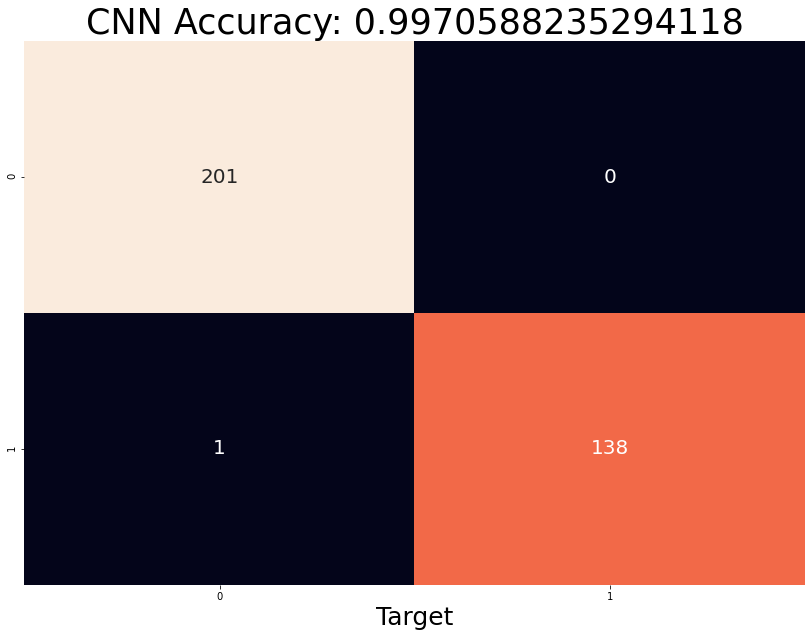

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

predicted_y = model.predict_classes(test_img)
plt.subplots(figsize=(14,10))
sns.heatmap(confusion_matrix(predicted_y, test_label), annot=True, fmt="1.0f", cbar=False, annot_kws={"size": 20})
plt.title(f"CNN Accuracy: {accuracy_score(predicted_y, test_label)}",fontsize=35)
plt.xlabel("Target", fontsize=25)
plt.show()

<br>

### * 결과 시각화 -2

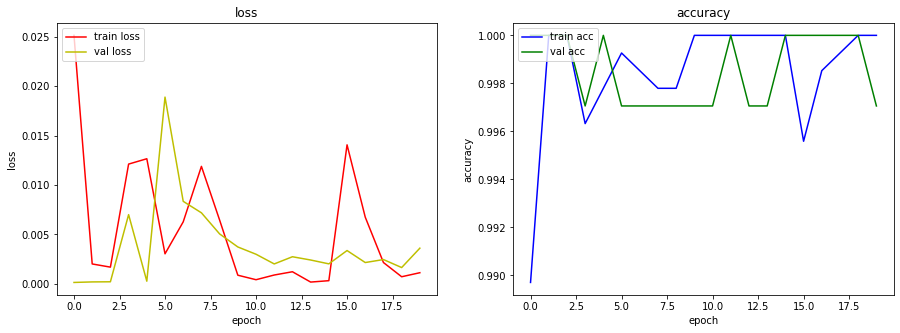

In [11]:
# loss, accuracy 추이

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)

plt.plot(history.history['loss'], 'r', label='train loss')
plt.plot(history.history['val_loss'], 'y', label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.title('loss')

plt.subplot(1, 2, 2)

plt.plot(history.history['accuracy'], 'b', label='train acc')
plt.plot(history.history['val_accuracy'], 'g', label='val acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='upper left')
plt.title('accuracy')

plt.show()
